## First: import necessary modules

In [1]:
#imports

%matplotlib widget

# python core
import os
import datetime as dt
from collections import defaultdict

# python libraries
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# themachinethatgoesping modules
from themachinethatgoesping.echosounders import kongsbergall    # Filehandlers for kongsbergall
from themachinethatgoesping.echosounders import index_functions # Helper functions for finding echosounder files
from themachinethatgoesping import echosounders
from themachinethatgoesping import pingprocessing 
from themachinethatgoesping import tools as pingtools

In [2]:
# helper functions
close_plots = True
def create_figure(name: str, return_ax: bool = True):
    """Helper function to create a figure with a given name that returns the figure and axis
    """
    if close_plots:
        plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name

    if return_ax:
        return fig, fig.subplots()
    return fig

def set_ax_timeformat(ax, timeformat = "%d-%m-%Y %H:%M:%S"):
    if not hasattr(ax, '__iter__'):
        ax = [ax]
    
    for a in ax:
        a.xaxis.set_major_formatter(mdates.DateFormatter(timeformat))
        a.xaxis.set_major_locator(mdates.AutoDateLocator())
        a.tick_params(axis='x', rotation=30)

# 
def clear_memory():
    import gc
    gc.collect()
    
    import ctypes
    libc = ctypes.CDLL("libc.so.6") # clearing cache 
    libc.malloc_trim(0)


def get_em2040_pings(folders, nfiles=None):
    # --- find all files ---
    files   = index_functions.find_files(folders, [".all", ".wcd"])
    
    # --- init cache paths ---
    cache_paths = index_functions.get_cache_file_paths(files)

    if nfiles is not None:
        files.sort()
        files = files[:nfiles]
    
    # --- Load the data EM2040 ---
    fm = kongsbergall.KongsbergAllFileHandler(files, file_cache_paths=cache_paths, init=False)
    
    # correct transducer offsets by 0.5m
    fm.configuration_interface.init_from_file(file_cache_paths=cache_paths)
    for c in fm.configuration_interface.per_file():
        s = c.read_sensor_configuration()
        for t in s.get_target_ids():
            if "TRX" in t:
                T = s.get_target(t)
                T.z += 0.5
                s.add_target(t, T)
    
        c.set_sensor_configuration(s)
    fm.ping_interface.init_from_file(file_cache_paths=cache_paths)

    return fm.get_pings()

## Open files from a survey

#### Find files (.all/.wcd)

In [3]:
# define a list of folder(s) to search for raw data files
# notes: 
#   - subdirectories will be searched as well
#   - you can add multiple folders by appending them to the list
#   - pair of files (e.g. .all and .wcd) don't have to be in the same folder
folders = []
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Stations")
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Transect")


#### Open EM2040 files

In [4]:
# open files in the specified folders and extract pings
em2040_pings = get_em2040_pings(folders,nfiles=50)
print()
print(f'Initial pings: {len(em2040_pings)}')

#select only pings from the required transducer
channel_ids = em2040_pings.find_channel_ids()
if len(channel_ids) != 2:
    raise RuntimeError(f"Len of channel_ids should be 2! {channel_ids}")
    
em2040_trx1_pings = em2040_pings(channel_ids[0])
em2040_trx2_pings = em2040_pings(channel_ids[1])
print(f'Pings from channel {em2040_trx1_pings.find_channel_ids()[0]}: {len(em2040_trx1_pings)}')
print(f'Pings from channel {em2040_trx2_pings.find_channel_ids()[0]}: {len(em2040_trx2_pings)}')

em2040_trx1_pings = pingprocessing.filter_pings.by_features(em2040_trx1_pings, ['watercolumn', 'bottom'])
em2040_trx2_pings = pingprocessing.filter_pings.by_features(em2040_trx2_pings, ['watercolumn', 'bottom'])
print(f'Pings from channel {em2040_trx1_pings[0].get_channel_id()} with watercolumn: {len(em2040_trx1_pings)}')
print(f'Pings from channel {em2040_trx2_pings[0].get_channel_id()} with watercolumn: {len(em2040_trx2_pings)}')

#delete not used pings
del em2040_pings

#clear_memory
clear_memory()

Found 288 files
indexing files ⢀ 99% :00s<00m:00s] [Found: 864147 datagrams in 50 files (2023MB)]                                              
Initializing KongsbergAllConfigurationDataInterface from file data ⢀ 100% :00s<00m:00s] [Done]        
Initializing KongsbergAllNavigationDataInterface from file data ⠁ 100% :00s<00m:00s] [Done]        
Initializing KongsbergAllPingDataInterface from file data ⠈ 96% :00s<00m:00s] [Done]                                              

Initial pings: 37131
Pings from channel TRX-2004: 18566
Pings from channel TRX-2031: 18565
Pings from channel TRX-2004 with watercolumn: 18553
Pings from channel TRX-2031 with watercolumn: 18553


## Create echograms of the data

In [5]:
ping = em2040_trx1_pings[0]

In [6]:
c = ping.watercolumn.get_calibration()

In [7]:
hash(c)

333349845276994145

In [8]:
c.hash()

16474250909772851802

#### define echogram function

In [9]:
from collections import OrderedDict

class fake_tqdm(object):
    def __init__(self, w_prg):
        self.w_prg = w_prg
        
    def __call__(self, list_like):
        self.list_like = list_like
        self.list_iter = iter(list_like)
        self.index = 0
        self.total = len(list_like)
        self.w_prg.max = self.total
        self.w_prg.value = 0
        return self
        
    def __iter__(self):
        return self
    
    def __next__(self):
        self.index += 1
        self.w_prg.value = self.index
        return next(self.list_iter)
    
    def __len__(self):
        return self.total
    
    def update(self):
        self.index += 1
        next(self.list_iter)
        self.w_prg.value = self.index
        
    def close(self):
        pass

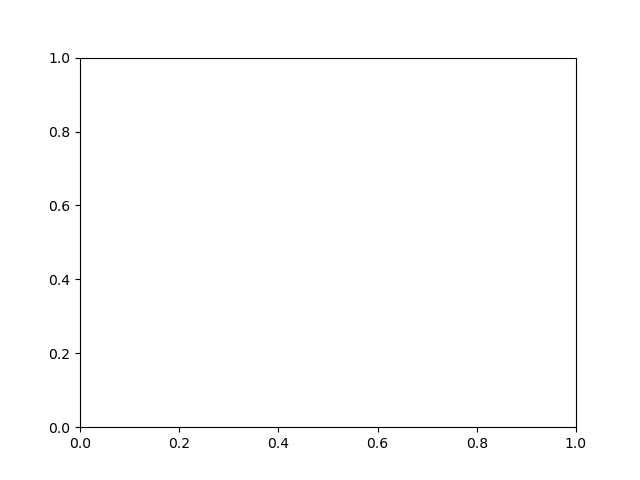

In [10]:
plt.close("WCI")
fig_wci = plt.figure("WCI")
ax_wci = fig_wci.subplots()

In [11]:
em2040_trx1_pings[0].file_data.get_file_ping_counter()

36757

In [12]:
em2040_trx2_pings[0].file_data.get_file_ping_counter()

36757

In [13]:
i,j = 0,0

filtered_pings = []
for _,_ in zip(tqdm(em2040_trx1_pings),em2040_trx2_pings):
    p1 = em2040_trx1_pings[i]
    p2 = em2040_trx2_pings[j]
    f1 = p1.file_data.get_file_ping_counter()
    f2 = p2.file_data.get_file_ping_counter()

    while f1 < f2:
        i += 1
        p1 = em2040_trx1_pings[i]
        f1 = p1.file_data.get_file_ping_counter()
        
    while f2 < f1:
        j += 1
        p2 = em2040_trx2_pings[j]
        f2 = p2.file_data.get_file_ping_counter()
    
    filtered_pings.append(p1)
    filtered_pings.append(p2)

    i+=1
    j+=1
    if i == len(em2040_trx1_pings): break
    if j == len(em2040_trx2_pings): break

len(filtered_pings)

  0%|          | 0/18553 [00:00<?, ?it/s]

37100

In [14]:
df_2004 = pd.read_hdf('beam-offsets.hd5','TRX-2004')
df_2031 = pd.read_hdf('beam-offsets.hd5','TRX-2031')

correction = {}
calibration = defaultdict(echosounders.filetemplates.WaterColumnCalibration)

val_key = 'vals_median'
val_key = 'vals_q05'
correction['TRX-2004'] = pingtools.vectorinterpolators.AkimaInterpolatorFF(df_2004['angle'].values, df_2004[val_key].values)
correction['TRX-2031'] = pingtools.vectorinterpolators.AkimaInterpolatorFF(df_2031['angle'].values, df_2031[val_key].values)
calibration['TRX-2004'].set_offset_per_beamangle(df_2004['angle_conv'].values, -df_2004[val_key].values)
calibration['TRX-2031'].set_offset_per_beamangle(df_2031['angle_conv'].values, -df_2031[val_key].values)

#ping.watmn.get_av(ercolu

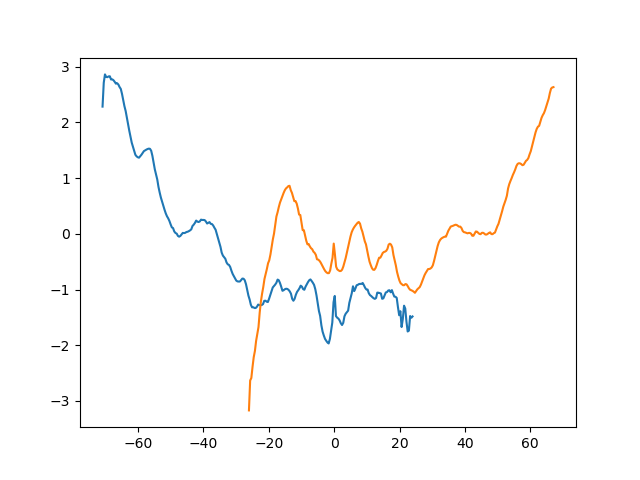

In [15]:
fig,ax = create_figure('2004')

ping = filtered_pings[10]
a = ping.bottom.get_beam_crosstrack_angles()
c = correction[ping.get_channel_id()](ping.bottom.get_beam_crosstrack_angles())
ax.plot(a,c,label=ping.get_channel_id())
ping = filtered_pings[11]
a = ping.bottom.get_beam_crosstrack_angles()
c = correction[ping.get_channel_id()](ping.bottom.get_beam_crosstrack_angles())
ax.plot(a,c,label=ping.get_channel_id())

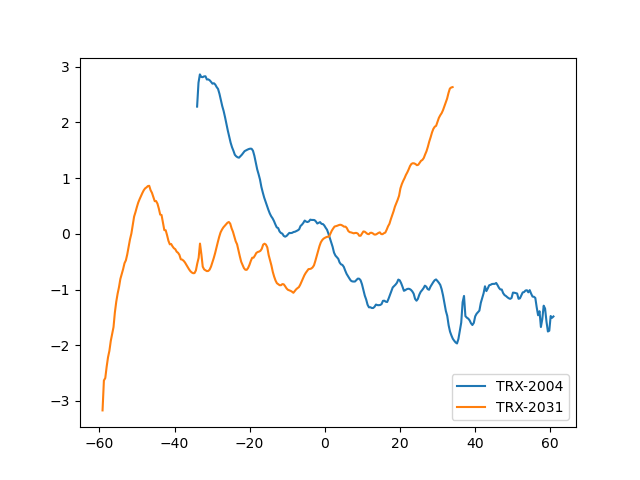

In [16]:
fig,ax = create_figure('2031')

ping = filtered_pings[10]
a = ping.bottom.get_beam_crosstrack_angles()
w = ping.watercolumn.get_beam_crosstrack_angles()
c = correction[ping.get_channel_id()](ping.bottom.get_beam_crosstrack_angles())
ax.plot(w,c,label=ping.get_channel_id())
ping = filtered_pings[11]
a = ping.bottom.get_beam_crosstrack_angles()
w = ping.watercolumn.get_beam_crosstrack_angles()
c = correction[ping.get_channel_id()](ping.bottom.get_beam_crosstrack_angles())
ax.plot(w,c,label=ping.get_channel_id())
ax.legend()

In [17]:
for ping in tqdm(filtered_pings):
    ping.watercolumn.set_calibration(calibration[ping.get_channel_id()])

  0%|          | 0/37100 [00:00<?, ?it/s]

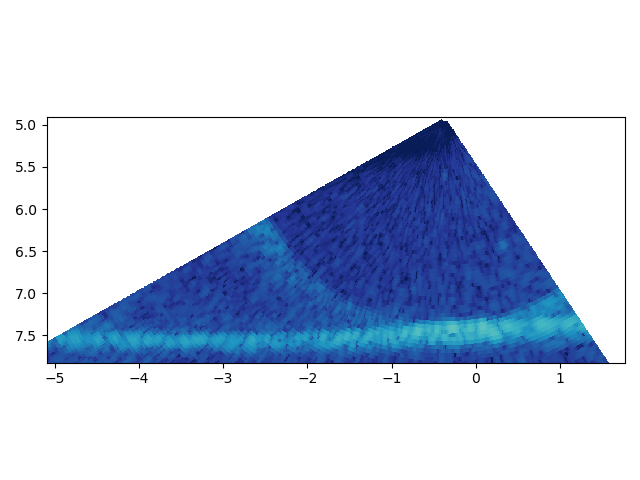

IntProgress(value=0, description='Stacking:', max=10)

FloatSlider(value=-1.0, max=50.0, min=-1.0, step=1.0)

FloatSlider(value=-90.0, max=150.0, min=-150.0, step=5.0)

FloatSlider(value=50.0, max=150.0, min=-150.0, step=5.0)

IntSlider(value=0, max=37099)

IntSlider(value=1024, max=2048, min=1)

In [18]:
from ipywidgets import *
from time import time
import themachinethatgoesping.pingprocessing.watercolumn.make_image as mi
import themachinethatgoesping.pingprocessing.watercolumn.helper.make_image_helper as mi_hlp

#filtered_pings, transducers = group_dual_pings(fm.get_pings.get_sorted_by_time())

fig_wci.set_tight_layout(True)

last_split_plot = 100

#@widgets.interact
#@debounce(0.1)
def update(w):  
    try:
        if w_protect_stack.value:
            if w['owner'] != w_wci_stack:
                if float(w_text_execut2ion_time.value) > 0.5:
                    w_wci_stack.value = w_wci_stack.value * 0.5 / float(w_text_execution_time.value)
        if w_wci_stack.value > 100:
            w_wci.step = int(w_wci_stack.value/2)
        else:
            w_wci.step = 1
    except Exception as e:
        pass
    
    w_text_num_total.value = str(int(w_text_num_total.value) +1)
    w_text_num_active.value = str(int(w_text_num_active.value) +1)
    
    t = time()
    global a, last_split_plot, ax_wci, fig_wci, ping1, ping2
    a = w
    #print(w)
    wci_index = w_wci.value
    wci_stack = w_wci_stack.value
    wci_stack_step = w_wci_stack_step.value
    cmin = w_cmin.value
    cmax = w_cmax.value
    aspect = w_aspect.value
    hsize = w_hsize.value
    heads = w_heads.value
    interpolation = w_interpolation.value
    maxz = w_z.value
    from_bottom = w_from_bottom.value
    threshold_white = w_threshold.value
    linear_mean = w_linear_stack.value
     
    ping = filtered_pings[wci_index]
    
    if wci_stack > 1:
        max_index = wci_index+wci_stack
        if max_index > len(filtered_pings):
            max_index = len(filtered_pings)
        pings = []
        for p in filtered_pings[wci_index:max_index:wci_stack_step]:
            pings.append(p)
                
        #pings = pings[::2]
    

    try:
        if wci_stack > 1:
            wci,extent = mi.make_wci_stack(pings,hsize,progress_bar=progress_bar,linear_mean=linear_mean,from_bottom_xyz=from_bottom, wci_value=w_av.value)
        else:
            if heads == 'split_dual_rect':
                match w_av.value:
                    case 'amp':
                        wci = ping.watercolumn.get_amplitudes()
                    case 'sv':
                        wci = ping.watercolumn.get_sv()
                    case 'av':
                        wci = ping.watercolumn.get_av()
                    case _:
                        raise ValueError(f"Invalid value for wci_value: {wci_value}. Choose any of ['av', 'amp', 'sv'].")
                extent = [0, ping.watercolumn.get_number_of_beams(),0, ping.watercolumn.get_number_of_samples_per_beam()[0]]
            else:        
                wci,extent = mi.make_wci(ping,hsize,from_bottom_xyz=from_bottom, wci_value=w_av.value)
        
                    
        ax_wci.clear()
            
        mapable = ax_wci.imshow(wci.transpose(),aspect=aspect, extent = extent, cmap='YlGnBu_r',vmin=cmin, vmax=cmax,interpolation=interpolation)
        
        if not heads == 'split_dual_rect':
            if not maxz == -1:
                ax_wci.set_ylim(maxz,0)
                               
        w_text_num_active.value = str(int(w_text_num_active.value) -1)
        w_text_execution_time.value = str(round(time()-t,3))
            
        
    except Exception as e:
        print(e)
        #pass
        raise (e)


w_z = FloatSlider(min=-1, max=50, step=1, value = -1)
w_cmin = FloatSlider(min=-150, max=150, step=5, value = -90)
w_cmax = FloatSlider(min=-150, max=150, step=5, value = 50)
w_wci = IntSlider(min=0, max=len(filtered_pings)-1, step=1, value =0)
w_hsize = IntSlider(min=1, max=2048, step=1, value = 1024)

w_from_bottom = Checkbox(description="from bottom", value=False)
w_linear_stack = Checkbox(description="linear stack", value=True)
w_protect_stack = Checkbox(description="protect stacking time", value=False)
w_threshold = Checkbox(description="threshhold white", value=False)

w_av = Dropdown(options=['av', 'sv', 'amp'], value='av')
w_aspect = Dropdown(options=['auto', 'equal'], value='equal')
w_heads = Dropdown(options=['blend_dual', 'blend_dual_inverse', 'split_dual', 'split_dual_rect'], value='blend_dual')
w_interpolation = Dropdown(options=['antialiased', 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'], value='nearest')
w_wci_stack = IntText(
    value=1,
    description='stack:',
    disabled=False
)
w_wci_stack_step = IntText(
    value=1,
    description='stack step:',
    disabled=False
)

w_text_num_total = Text(
    value='0',
    placeholder='0',
    description='Total executions:',
    disabled=False   
)
w_text_num_active = Text(
    value='0',
    placeholder='0',
    description='Active executions:',
    disabled=False   
)
w_text_execution_time = Text(
    value='0',
    placeholder='0',
    description='Time of last execution:',
    disabled=False   
)
w_progress = IntProgress(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Stacking:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)
progress_bar = fake_tqdm(w_progress)

box_text = HBox([w_text_num_total,w_text_num_active,w_text_execution_time])
box_options = HBox([w_aspect,w_heads,w_interpolation,w_wci_stack,w_wci_stack_step])
box_check = HBox([w_av, w_from_bottom,w_linear_stack,w_protect_stack, w_threshold])

w_z.observe(update, names=['value'])
w_cmin.observe(update, names=['value'])
w_cmax.observe(update, names=['value'])
w_wci.observe(update, names=['value'])
w_wci_stack.observe(update, names=['value'])
w_wci_stack_step.observe(update, names=['value'])
w_hsize.observe(update, names=['value'])
w_aspect.observe(update, names=['value'])
w_from_bottom.observe(update, names=['value'])
w_threshold.observe(update, names=['value'])
w_av.observe(update, names=['value'])
w_linear_stack.observe(update, names=['value'])
w_heads.observe(update, names=['value'])
w_interpolation.observe(update, names=['value'])


update(0)
display(fig_wci.canvas,w_progress, box_text, box_options, box_check, w_z, w_cmin,w_cmax,w_wci,w_hsize)

In [19]:
w_av.value

'av'